# Convolutional Neural Network, Big Data & Building a Pipeline

In this notebook we will some data exploration, preprocessing of data and develop a convolutional neural network model using the v2 plant seedlings dataset available in [kaggle](https://www.kaggle.com/datasets/vbookshelf/v2-plant-seedlings-dataset). 

Note that for the Sheperd's Purse folder it is necessary to remove the ' so that it reads Sheperds Purse.

## Objetives

Correctly identify the weed type from a variety of weed and crop RGB images

## Load Data: images

In [1]:
DATA_FOLDER = "dataset"

The differents types of weed are stored in differents directories:

In [2]:
import os
classes = os.listdir(DATA_FOLDER)
classes

['Black-grass',
 'Small-flowered Cranesbill',
 'Sheperds Purse',
 'Common wheat',
 'Scentless Mayweed',
 'Charlock',
 'Common Chickweed',
 'Sugar beet',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Cleavers']

Let's create a dataframe that stores the path to the image in one column and the class of the weed in the other:

In [3]:
from glob import glob
import pandas as pd

df = []
for class_dir in os.listdir(DATA_FOLDER):
    path = os.path.join(DATA_FOLDER, class_dir)
    
    for img in glob(os.path.join(path, "*.png")):
        df.append(pd.DataFrame([img, class_dir]).T)
        
df = pd.concat(df, axis=0, ignore_index=True)
df.columns = ["image", "target"]
df.head()

,image,target
0,dataset/Black-grass/173.png,Black-grass
1,dataset/Black-grass/52.png,Black-grass
2,dataset/Black-grass/285.png,Black-grass
3,dataset/Black-grass/242.png,Black-grass
4,dataset/Black-grass/83.png,Black-grass


Let's see how many images we have per class

In [4]:
df.target.value_counts()

Loose Silky-bent             762
Common Chickweed             713
Scentless Mayweed            607
Small-flowered Cranesbill    576
Fat Hen                      538
Sugar beet                   463
Charlock                     452
Cleavers                     335
Black-grass                  309
Sheperds Purse               274
Maize                        257
Common wheat                 253
Name: target, dtype: int64

We will ignore the imbalancing in the data for the porpouse of this implimentation

We can visualize some images to have an idea of what we have

In [5]:
import cv2
import itertools as it
import matplotlib.pyplot as plt

def plot_nine_images_per_class(df, label):
    rows, cols = 3, 3
    
    fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
    
    for n, (i, j) in enumerate(it.product(range(rows), range(cols))): 
        tmp = df[df.target == label]
        tmp.reset_index(drop=True, inplace=True)
        im = cv2.imread(tmp.loc[n, "image"])
        axs[i, j].imshow(im)

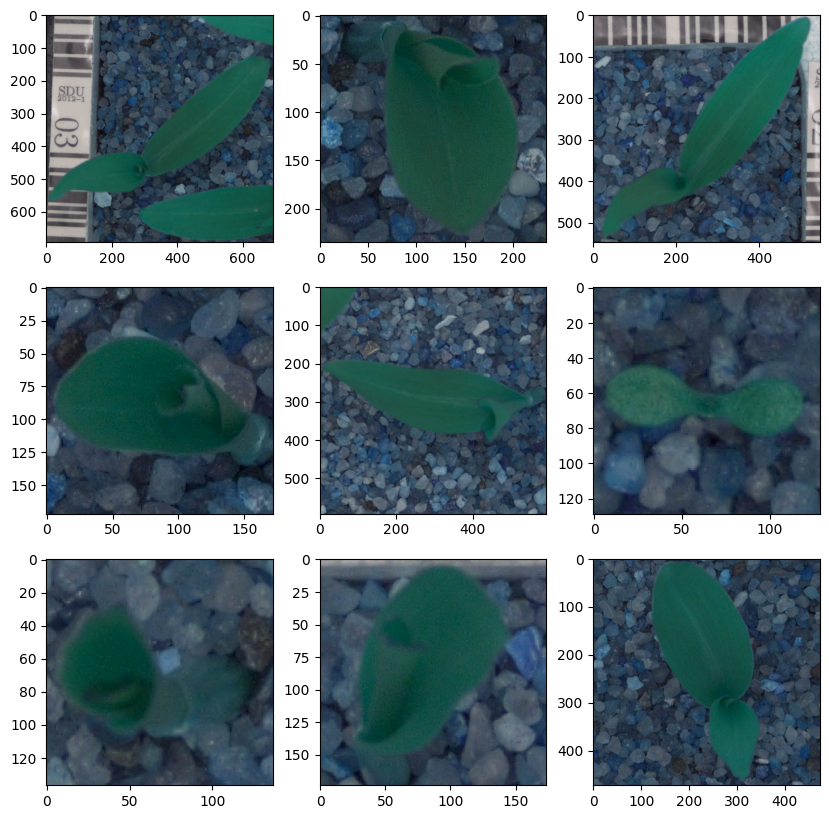

In [6]:
plot_nine_images_per_class(df, "Maize")
plt.show()

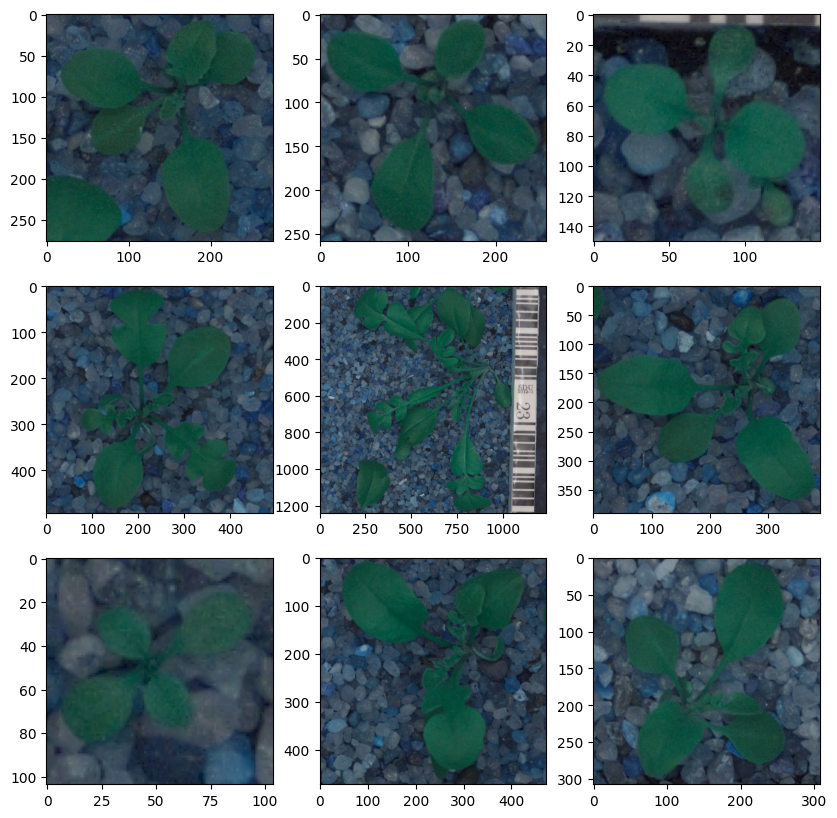

In [7]:
plot_nine_images_per_class(df, "Sheperds Purse")
plt.show()

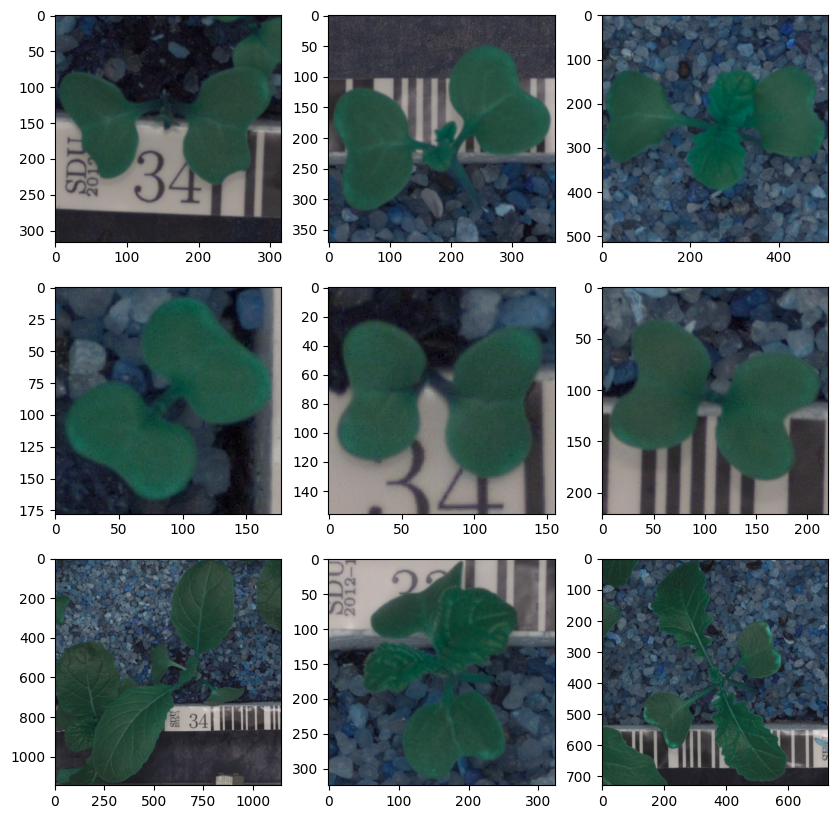

In [8]:
plot_nine_images_per_class(df, "Charlock")
plt.show()

It can be seen that the images are not all of the same size.

## Preprocessing

In [9]:
X, y = df.image, df.target

For neural network we need that all the images be in the same size

In [10]:
IMAGE_SIZE = 128

def im_resize(img_path):
    im = cv2.imread(img_path)
    im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
    return im

tmp = im_resize(X[7])
tmp.shape

(128, 128, 3)

The 3 corresponds with the 3 colors of RGB, but the shape of the dataset must be (number of observations, image with, image length, 3)

In [11]:
import numpy as np

def create_dataset(X, image_size): 
    return np.array([im_resize(x) for x in X], dtype=np.float32)

X = create_dataset(X, IMAGE_SIZE)

In [12]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

encoder = LabelEncoder()
encoder.fit(y)

y = tf.keras.utils.to_categorical(encoder.transform(y))

y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=101
)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(4431, 128, 128, 3) (1108, 128, 128, 3)
(4431, 12) (1108, 12)


## Basic CNN training

In [14]:
kernel_size = (3, 3)
pool_size = (2, 2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

model = tf.keras.models.Sequential()
model.add(
    tf.keras.layers.Conv2D(
        first_filters, 
        kernel_size, 
        activation="relu",
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    )
)
model.add(tf.keras.layers.Conv2D(first_filters, kernel_size, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=pool_size))
model.add(tf.keras.layers.Dropout(dropout_conv))

model.add(tf.keras.layers.Conv2D(second_filters, kernel_size, activation="relu"))
model.add(tf.keras.layers.Conv2D(second_filters, kernel_size, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=pool_size))
model.add(tf.keras.layers.Dropout(dropout_conv))

model.add(tf.keras.layers.Conv2D(third_filters, kernel_size, activation="relu"))
model.add(tf.keras.layers.Conv2D(third_filters, kernel_size, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=pool_size))
model.add(tf.keras.layers.Dropout(dropout_conv))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dropout(dropout_dense))
model.add(tf.keras.layers.Dense(12, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 62, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 64)        36928     
                                                        

In [15]:
model.compile(
    tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [16]:
batch_size = 10
epochs = 10

In [17]:
filepath = "model.h5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor="accuracy", verbose=1, save_best_only=True, mode="max"
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="accuracy", factor=0.5, patience=1, verbose=1, mode="max", min_lr=0.00001
)

callbacks_list = [checkpoint, reduce_lr]

Train the CNN

In [18]:
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size, 
    validation_split=0.1, 
    epochs=epochs, 
    verbose=2, 
    callbacks=callbacks_list,
)

Epoch 1/10

Epoch 1: accuracy improved from -inf to 0.15576, saving model to model.h5
399/399 - 88s - loss: 0.3644 - accuracy: 0.1558 - val_loss: 0.3643 - val_accuracy: 0.3896 - lr: 1.0000e-04 - 88s/epoch - 221ms/step
Epoch 2/10

Epoch 2: accuracy improved from 0.15576 to 0.37397, saving model to model.h5
399/399 - 87s - loss: 0.2367 - accuracy: 0.3740 - val_loss: 0.2258 - val_accuracy: 0.5270 - lr: 1.0000e-04 - 87s/epoch - 217ms/step
Epoch 3/10

Epoch 3: accuracy improved from 0.37397 to 0.52170, saving model to model.h5
399/399 - 87s - loss: 0.1934 - accuracy: 0.5217 - val_loss: 0.1696 - val_accuracy: 0.6486 - lr: 1.0000e-04 - 87s/epoch - 218ms/step
Epoch 4/10

Epoch 4: accuracy improved from 0.52170 to 0.62077, saving model to model.h5
399/399 - 87s - loss: 0.1617 - accuracy: 0.6208 - val_loss: 0.1402 - val_accuracy: 0.7297 - lr: 1.0000e-04 - 87s/epoch - 217ms/step
Epoch 5/10

Epoch 5: accuracy improved from 0.62077 to 0.68272, saving model to model.h5
399/399 - 87s - loss: 0.1390 -

Plot the accuracy and the loss in the training set

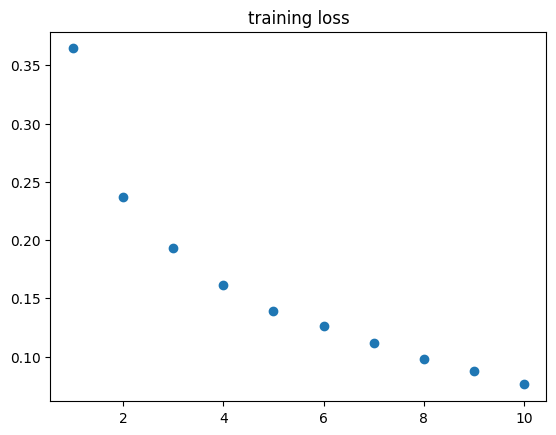

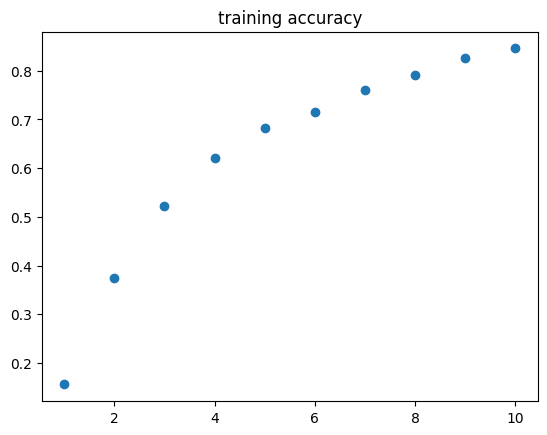

In [19]:
accuracy = history.history["accuracy"]
loss = history.history["loss"]

epochs_vals = np.arange(1, epochs + 1)

plt.plot(epochs_vals, loss, "o")
plt.title("training loss")
plt.show()

plt.plot(epochs_vals, accuracy, "o")
plt.title("training accuracy")
plt.show()

Predict in the test set

In [20]:
ypred = np.argmax(model.predict(X_test, verbose=1), axis=1)
ypred

35/35 [==============================] - 8s 217ms/step


array([ 3,  6,  2, ...,  3,  8, 11])

In [21]:
ytest = np.argmax(y_test, axis=1)

Let's see the confusion matrix

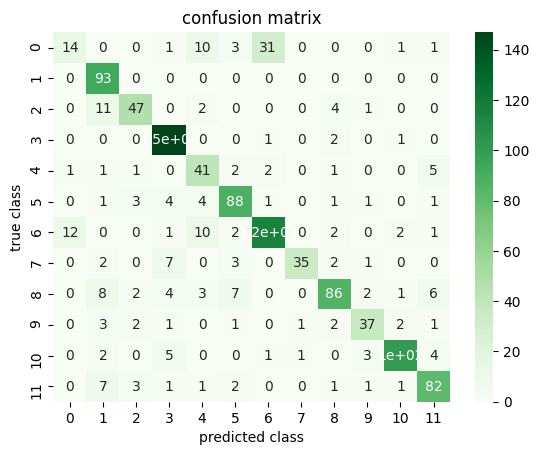

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(ytest, ypred)

fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xlabel("predicted class")
ax.set_ylabel("true class")
ax.set_title("confusion matrix")
plt.show()

and calculate the total accuracy on test set

In [23]:
from sklearn.metrics import accuracy_score, classification_report

accuracy_score(ytest, ypred, normalize=True)

0.7996389891696751

In [24]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.52      0.23      0.32        61
           1       0.73      1.00      0.84        93
           2       0.81      0.72      0.76        65
           3       0.86      0.97      0.91       151
           4       0.58      0.76      0.66        54
           5       0.81      0.85      0.83       104
           6       0.76      0.79      0.78       145
           7       0.95      0.70      0.80        50
           8       0.85      0.72      0.78       119
           9       0.80      0.74      0.77        50
          10       0.93      0.86      0.89       117
          11       0.81      0.83      0.82        99

    accuracy                           0.80      1108
   macro avg       0.78      0.76      0.76      1108
weighted avg       0.80      0.80      0.79      1108

